# TP2 - Introdução a Banco de Dados



# 1. Titulo
## Banco de Dados ANCINE de Produções Nacionais e Exibição



# 2. Membros

Arthur Guilherme Rodrigues Luz - 2019006396 \\
João Antonio Oliveira Pedrosa  - 2019006752 \\
Lorrayne Somerlatte dos Santos - 2018065895 \\
Pedro Henrique Dalla-Lana     - 2020420613 \\

# 3. Descrição dos Dados

O projeto foi baseado nos dados retirados diretamente do Portal Brasileiro de Dados Abertos, na subseção da Agência Nacional do Cinema (ANCINE). Nosso acesso aos dados foi puxado de um repositório no GitHub [1]
<br/>
A finalidade é catalogar e relacionar informações sobre obras cinematográficas nacionais e alguns detalhes de sua produção, com as diversas salas de exibição, horários e programações espalhadas por todo o país.
<br/>
Os dados foram extraídos do site do governo [2] e tratados, extraindo apenas as informações julgadas relevantes. Extraímos os Diretores [3] e produtores [4] cadastrados na agência, e, tendo em vista que cada obra possui um identificador 'CPB' expresso em cada uma das tabelas, fomos capazes de mesclá-las traçar um "perfil" completo de cada obra brasileira com uma riqueza maior de informações.
<br/>
Além disso, extraímos informações a respeito dos complexos/salas de exibição em todo território nacional, dessa forma, nosso esquema de banco de dados é capaz de informar não apenas detalhes sobre a obra em si, também é capaz de retornar quando e onde determinada obra foi exibida.
<br/>
[1] https://github.com/mrcolorblind/tp2_ibd
<br/>
[2] https://dados.gov.br/organization/agencia-nacional-do-cinema-ancine
<br/>
[2] https://dados.gov.br/dataset/diretores-pessoa-fisica-credenciados-na-ancine
<br/>
[2] https://dados.gov.br/dataset/produtores-pessoa-fisica-credenciados-na-ancine
<br/><br/>
Segue o código utilizado para o processamento dos dados e inserção deles no banco de dados:

## 3.1 Importando módulos e definindo funções

In [ ]:
import sqlite3
from random import randint
from datetime import datetime
import pandas as pd
import numpy as np
import io
import math
from tqdm import tqdm

def trim(string):
    string = string.replace(".", "")
    string = string.replace("'", "")
    string = string.replace("/", "")
    string = string.replace("-", "")
    return string

## 3.2 Criando a base de dados e importando arquivos

In [ ]:
# Importando os arquivos de dados
!wget "https://github.com/mrcolorblind/tp2_ibd/raw/master/data/ProdutorasIndependentes(u).xlsx"
!wget "https://github.com/mrcolorblind/tp2_ibd/raw/master/data/DiretorCPB(u).xlsx"
!wget "https://github.com/mrcolorblind/tp2_ibd/raw/master/data/ProdutorCPB(u).xlsx"
!wget "https://github.com/mrcolorblind/tp2_ibd/raw/master/data/ProdutorasIndependentes(u).xlsx"
!wget "https://github.com/mrcolorblind/tp2_ibd/raw/master/data/SalasExibi%C3%A7%C3%A3oEComplexos(u).xlsx"
!wget "https://github.com/mrcolorblind/tp2_ibd/blob/master/data/CadastroObraBrasileiraCPB(u).xlsx?raw=true"
!wget "https://github.com/mrcolorblind/tp2_ibd/blob/master/data/DiretorProdutorECadastro.xlsx?raw=true"
!wget "https://github.com/mrcolorblind/tp2_ibd/blob/master/data/Diretor%20e%20Produtor.xlsx?raw=true"

--2021-03-17 23:43:31--  https://github.com/mrcolorblind/tp2_ibd/raw/master/data/ProdutorasIndependentes(u).xlsx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrcolorblind/tp2_ibd/master/data/ProdutorasIndependentes(u).xlsx [following]
--2021-03-17 23:43:31--  https://raw.githubusercontent.com/mrcolorblind/tp2_ibd/master/data/ProdutorasIndependentes(u).xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 331423 (324K) [application/octet-stream]
Saving to: ‘ProdutorasIndependentes(u).xlsx.2’

ProdutorasIndepende 100%[===================>] 323.66K  --.-KB/s    in 0.02s   

2021-03-17 23:43:31 (1

In [ ]:
# Criando o Banco de Dados
conn = sqlite3.connect('/content/ancine.db')
cursor = conn.cursor()

In [ ]:
# Script SQL para gerar as tabelas do Banco de Dados

sql = """
CREATE TABLE IF NOT EXISTS [diretor] (
  'registro' INTEGER PRIMARY KEY,
  'nome' VARCHAR(45) NULL,
  'naturalidade_diretor' VARCHAR(45) NULL
  );

CREATE TABLE IF NOT EXISTS [produtor] (
  'registro' INTEGER PRIMARY KEY,
  'cnpj' VARCHAR(14) NULL,
  'pais_origem' VARCHAR(45) NULL,
  'razao_social' VARCHAR(45) NULL
  );

CREATE TABLE IF NOT EXISTS [filme](
  'cpb' VARCHAR(45) NOT NULL,
  'ano' INT NULL,
  'titulo' VARCHAR(120) NOT NULL,
  'org_temporal' VARCHAR(45) NULL DEFAULT 'nao seriado',
  'tipo_obra' VARCHAR(45) NULL DEFAULT 'nao classificada',
  'data_cpb' DATETIME NULL,
  'qtd_episodios' INT NULL DEFAULT NULL,
  'produtor_registro' INT NOT NULL,
  'diretor_registro' INT NOT NULL,
  PRIMARY KEY ('cpb')
  );

CREATE TABLE IF NOT EXISTS [complexo](
  'registro' INT NOT NULL,
  'nome' VARCHAR(45) NULL,
  PRIMARY KEY ('registro')
  );

CREATE TABLE IF NOT EXISTS [exibidor] (
  'registro' INT NOT NULL,
  'cnpj' VARCHAR(14) NOT NULL,
  'nome' VARCHAR(45) NOT NULL,
  PRIMARY KEY ('registro')
  );

CREATE TABLE IF NOT EXISTS [sala](
  'registro' INT NOT NULL,
  'nome' VARCHAR(45) NULL,
  'qtd_assentos' INT NULL,
  'situacao_regular' INT NULL,
  'complexo_registro' INT NOT NULL,
  'exibidor_registro' INT NOT NULL,
  PRIMARY KEY ('registro')
  );

CREATE TABLE IF NOT EXISTS [municipio](
  'codigo_ibge' INT NOT NULL,
  'nome' VARCHAR(45) NULL,
  'uf' VARCHAR(45) NULL,
  PRIMARY KEY ('codigo_ibge')
  );

CREATE TABLE IF NOT EXISTS [sessao] (
  'filme_cpb' INT NOT NULL,
  'sala_registro' INT NOT NULL,
  'data_inicio' DATETIME NULL,
  'data_fim' DATETIME NULL,
  PRIMARY KEY ('filme_cpb', 'sala_registro')
  );

CREATE TABLE IF NOT EXISTS [complexo_em_municipio] (
  'municipio_codigo_ibge' INT NOT NULL,
  'complexo_registro' INT NOT NULL,
  PRIMARY KEY ('municipio_codigo_ibge', 'complexo_registro')
  );
  """

cursor.executescript(sql)

## 3.3 Populando as tabelas Sala, Complexo, Município e Exibidor

In [ ]:
salas = pd.read_excel("SalasExibiçãoEComplexos(u).xlsx")
salas.columns

Index(['NOME_SALA', 'REGISTRO_SALA', 'CNPJ_SALA', 'SITUACAO_SALA',
       'QUANTIDADE_ASSENTOS', 'NOME_COMPLEXO', 'REGISTRO_COMPLEXO',
       'PAGINA_ELETRONICA_COMPLEXO', 'ENDERECO_COMPLEXO',
       'NUMERO_ENDERECO_COMPLEXO', 'COMPLEMENTO_ENDERECO', 'BAIRRO_COMPLEXO',
       'MUNICIPIO_COMPLEXO', 'CODIGO_MUNICPIO_IBGE', 'UF_COMPLEXO',
       'COMPLEXO_ITINERANTE', 'OPERACAO_USUAL', 'EXIBIDOR',
       'REGISTRO_EXIBIDOR', 'CNPJ_EXIBIDOR', 'SITUACAO_EXIBIDOR',
       'GRUPO_EXIBIDOR'],
      dtype='object')

In [ ]:
# Acelerando o processo de inserção
sql = "PRAGMA foreign_keys = 0"
cursor.executescript(sql)
sql = "PRAGMA cache_size = 0"
cursor.executescript(sql)


# Script Inserir Salas e Complexos
for i in range(1000):
    if math.isnan(salas['REGISTRO_SALA'][i]): continue

    sala_reg      = salas['REGISTRO_SALA'][i]
    sala_nome     = salas['NOME_SALA'][i]
    sala_nome     = trim(sala_nome)
    sala_qtdass   = salas['QUANTIDADE_ASSENTOS'][i]
    sala_situ     = salas['SITUACAO_SALA'][i]
    sala_situ     = 1 if (sala_situ == 'EM FUNCIONAMENTO') else 0
    complexo_reg  = salas['REGISTRO_COMPLEXO'][i]
    exibidor_reg  = salas['REGISTRO_EXIBIDOR'][i]

    # Inserindo complexo
    query = "SELECT registro FROM complexo WHERE registro = " + str(complexo_reg)
    if(len(pd.read_sql_query(query, conn)) == 0):
        complexo_nome = salas['NOME_COMPLEXO'][i]
        complexo_nome = trim(complexo_nome)
        muni_ibge     = salas['CODIGO_MUNICPIO_IBGE'][i]
        
        sql = "INSERT INTO complexo ('registro', 'nome') VALUES ('"\
        + str(complexo_reg) + "','" + str(complexo_nome) + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break
        
        # Inserindo Município
        query = "SELECT codigo_ibge FROM municipio WHERE codigo_ibge = " + str(muni_ibge)
        if(len(pd.read_sql_query(query, conn)) == 0):
            muni_nome = salas['MUNICIPIO_COMPLEXO'][i]
            muni_nome = trim(muni_nome)
            muni_uf   = salas['UF_COMPLEXO'][i]
            sql = "INSERT INTO municipio ('codigo_ibge', 'nome', 'uf') VALUES ('"\
            + str(muni_ibge) + "','" + str(muni_nome) + "','" + str(muni_uf) +  "')"
            try:
                cursor.executescript(sql)
            except:
                print(sql)
                cursor.executescript(sql)
                break

        # Inserindo relação Complexo x Município
        sql = "INSERT INTO complexo_em_municipio ('municipio_codigo_ibge', 'complexo_registro') VALUES ('"\
        + str(muni_ibge) + "','" + str(complexo_reg) + "')" 
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break

    # Inserindo exibidor
    query = "SELECT registro FROM exibidor WHERE registro = "\
    + str(exibidor_reg)
    if(len(pd.read_sql_query(query, conn)) == 0):
        exibidor_cnpj = salas['CNPJ_EXIBIDOR'][i]
        exibidor_nome = salas['EXIBIDOR'][i]
        exibidor_nome = trim(exibidor_nome)
        sql = "INSERT INTO exibidor ('registro', 'nome', 'cnpj') VALUES ('"\
        + str(exibidor_reg) + "','" + str(exibidor_nome) + "','" + exibidor_cnpj + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break
    
    # Inserindo sala
    query = "SELECT registro FROM sala WHERE registro = "\
    + str(sala_reg)
    if(len(pd.read_sql_query(query, conn)) == 0):
        sql = "INSERT INTO sala ('registro', 'nome', 'qtd_assentos',"\
        +"'situacao_regular', 'complexo_registro', 'exibidor_registro') VALUES ('"\
        + str(sala_reg) + "','" + str(sala_nome) + "','" + str(sala_qtdass) + "','" + str(sala_situ)\
        + "','" + str(complexo_reg) + "','" + str(exibidor_reg) + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break

## 3.4 Populando as tabelas Filme, Diretor e Produtor

In [ ]:
filmes = pd.read_excel("DiretorProdutorECadastro.xlsx?raw=true")
filmes.columns

Index(['Unnamed: 0', 'CPB', 'TITULO_ORIGINAL', 'REQUERENTE',
       'CNPJ_CPF_REQUERENTE', 'TIPO_OBRA', 'SUBTIPO_OBRA', 'CLASSIFICACAO',
       'ORGANIZACAO_TEMPORAL', 'DURACAO', 'QUANTIDADE_EPISODIOS',
       'ANO_PRODUCAO', 'DT_EMISSAO_CPB', 'SEGMENTO_PRET_DIF',
       'COPRODUCAO_INTERNACIONAL', 'OBRA_REALIZADA_COM_FOMENTO',
       'OBRA_REALIZADA_COM_INVEST_FSA', 'DIRETOR', 'PAIS_DIRETOR',
       'CNPJ_CPF_PRODUTOR', 'PRODUTOR', 'PAIS_PRODUTOR'],
      dtype='object')

In [ ]:
# Acelerando o processo de inserção
sql = "PRAGMA foreign_keys = 0"
cursor.executescript(sql)
sql = "PRAGMA cache_size = 0"
cursor.executescript(sql)

# Script Inserir Diretor e Produtor

# Iremos inserir apenas uma amostra
for i in range(1000):
    #if math.isnan(filmes['CPB'][i]): continue

    filme_cpb     = filmes['CPB'][i]
    filme_cpb     = trim(filme_cpb)
    filme_ano     = filmes['ANO_PRODUCAO'][i]
    filme_nome    = str(filmes['TITULO_ORIGINAL'][i])
    filme_nome    = trim(filme_nome)
    filme_org     = filmes['ORGANIZACAO_TEMPORAL'][i]
    filme_tipo    = filmes['TIPO_OBRA'][i]
    filme_datacpb = filmes['DT_EMISSAO_CPB'][i]
    filme_eps     = filmes['QUANTIDADE_EPISODIOS'][i]
    prod_cnpj     = str(filmes['CNPJ_CPF_PRODUTOR'][i])
    prod_cnpj     = trim(prod_cnpj)
    dir_nome      = filmes['DIRETOR'][i]
    dir_nome      = trim(dir_nome)

    # Inserindo produtor
    query = "SELECT registro FROM produtor WHERE cnpj = '" + str(prod_cnpj) + "'"
    if(len(pd.read_sql_query(query, conn)) == 0):
        prod_pais  = filmes['PAIS_PRODUTOR'][i]
        prod_razao = filmes['PRODUTOR'][i]
        prod_razao = trim(prod_razao)
        
        sql = "INSERT INTO produtor ('registro', 'cnpj', 'pais_origem', 'razao_social') VALUES (NULL,'"\
         + str(prod_cnpj) + "','" + str(prod_pais) + "','" + str(prod_razao) + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break
    
    query        = "SELECT registro FROM produtor WHERE cnpj = '" + str(prod_cnpj) + "'"
    if(len(pd.read_sql_query(query, conn)) != 0):
        filme_prod   = pd.read_sql_query(query, conn)['registro'][0]
    else:
        print(prod_razao)
        print(query)
        break


    # Inserindo diretor
    query = "SELECT registro FROM diretor WHERE nome = '" + str(dir_nome) + "'"
    if(len(pd.read_sql_query(query, conn)) == 0):
        dir_pais = filmes['PAIS_DIRETOR'][i]
        
        sql = "INSERT INTO diretor ('registro', 'nome', 'naturalidade_diretor') VALUES (NULL, '"\
        + str(dir_nome) + "','" + str(dir_pais) + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break

    
    query = "SELECT registro FROM diretor WHERE nome = '" + str(dir_nome) + "'"
    filme_dir = pd.read_sql_query(query, conn)['registro'][0]

    # Inserindo filmes
    query = "SELECT cpb FROM filme WHERE cpb = '" + str(filme_cpb) + "'"
    if(len(pd.read_sql_query(query, conn)) == 0):
        sql = "INSERT INTO filme ('cpb', 'ano', 'titulo', 'org_temporal', 'tipo_obra', 'data_cpb',"\
        +"'qtd_episodios', 'produtor_registro', 'diretor_registro') VALUES ('"\
        + str(filme_cpb) + "','" + str(filme_ano) + "','" + str(filme_nome)\
        +  "','" + str(filme_org) + "','" +  str(filme_tipo) + "','" + str(filme_datacpb)\
        +  "','" + str(filme_eps) +  "','" + str(filme_prod) + "','" + str(filme_dir) + "')"
        try:
            cursor.executescript(sql)
        except:
            print(sql)
            cursor.executescript(sql)
            break

## 3.5 Gerando a relação Filme $\times$ Sala

In [ ]:
# Vamos gerar uma tabela relacionamento artificial entre Filmes e Salas
# representando que algum filme estava em cartaz em alguma sala durante
# certo período de tempo

query  = "SELECT registro FROM sala"
salas  = pd.read_sql_query(query, conn)
query  = "SELECT cpb FROM filme"
filmes = pd.read_sql_query(query, conn)
# Para cada sala, geraremos entradas na tabela
for i in range(len(salas)):
    sala_reg = str(salas['registro'][i])
    # Gerando de 0 a 10 entradas
    lf = []
    for j in range(randint(0, 10)):
        # Pegando um filme aleatório
        idx_filme = randint(0, len(filmes)-1)
        if idx_filme in lf: continue
        lf.append(idx_filme)
        filme_cpb = str(filmes['cpb'][idx_filme])
        # Data de Início Aleatória de Jan de 2019 até Dez 2020
        date_ini_unix  = randint(1546383345, 1609372545)
        date_ini       = str(datetime.fromtimestamp(date_ini_unix))[:-9]
        # Tempo de Duração Aleatório de 1 à 10 dias
        date_fim_unix  = date_ini_unix + randint(86400, 864000)
        date_fim       = str(datetime.fromtimestamp(date_fim_unix))[:-9]

        
        sql = "INSERT INTO sessao "\
        +"(filme_cpb, sala_registro, data_inicio, data_fim) VALUES ('"\
        + filme_cpb + "','" + sala_reg + "','" + date_ini + "','" + date_fim\
        + "')"
        cursor.executescript(sql)

# 4. Esquema ER

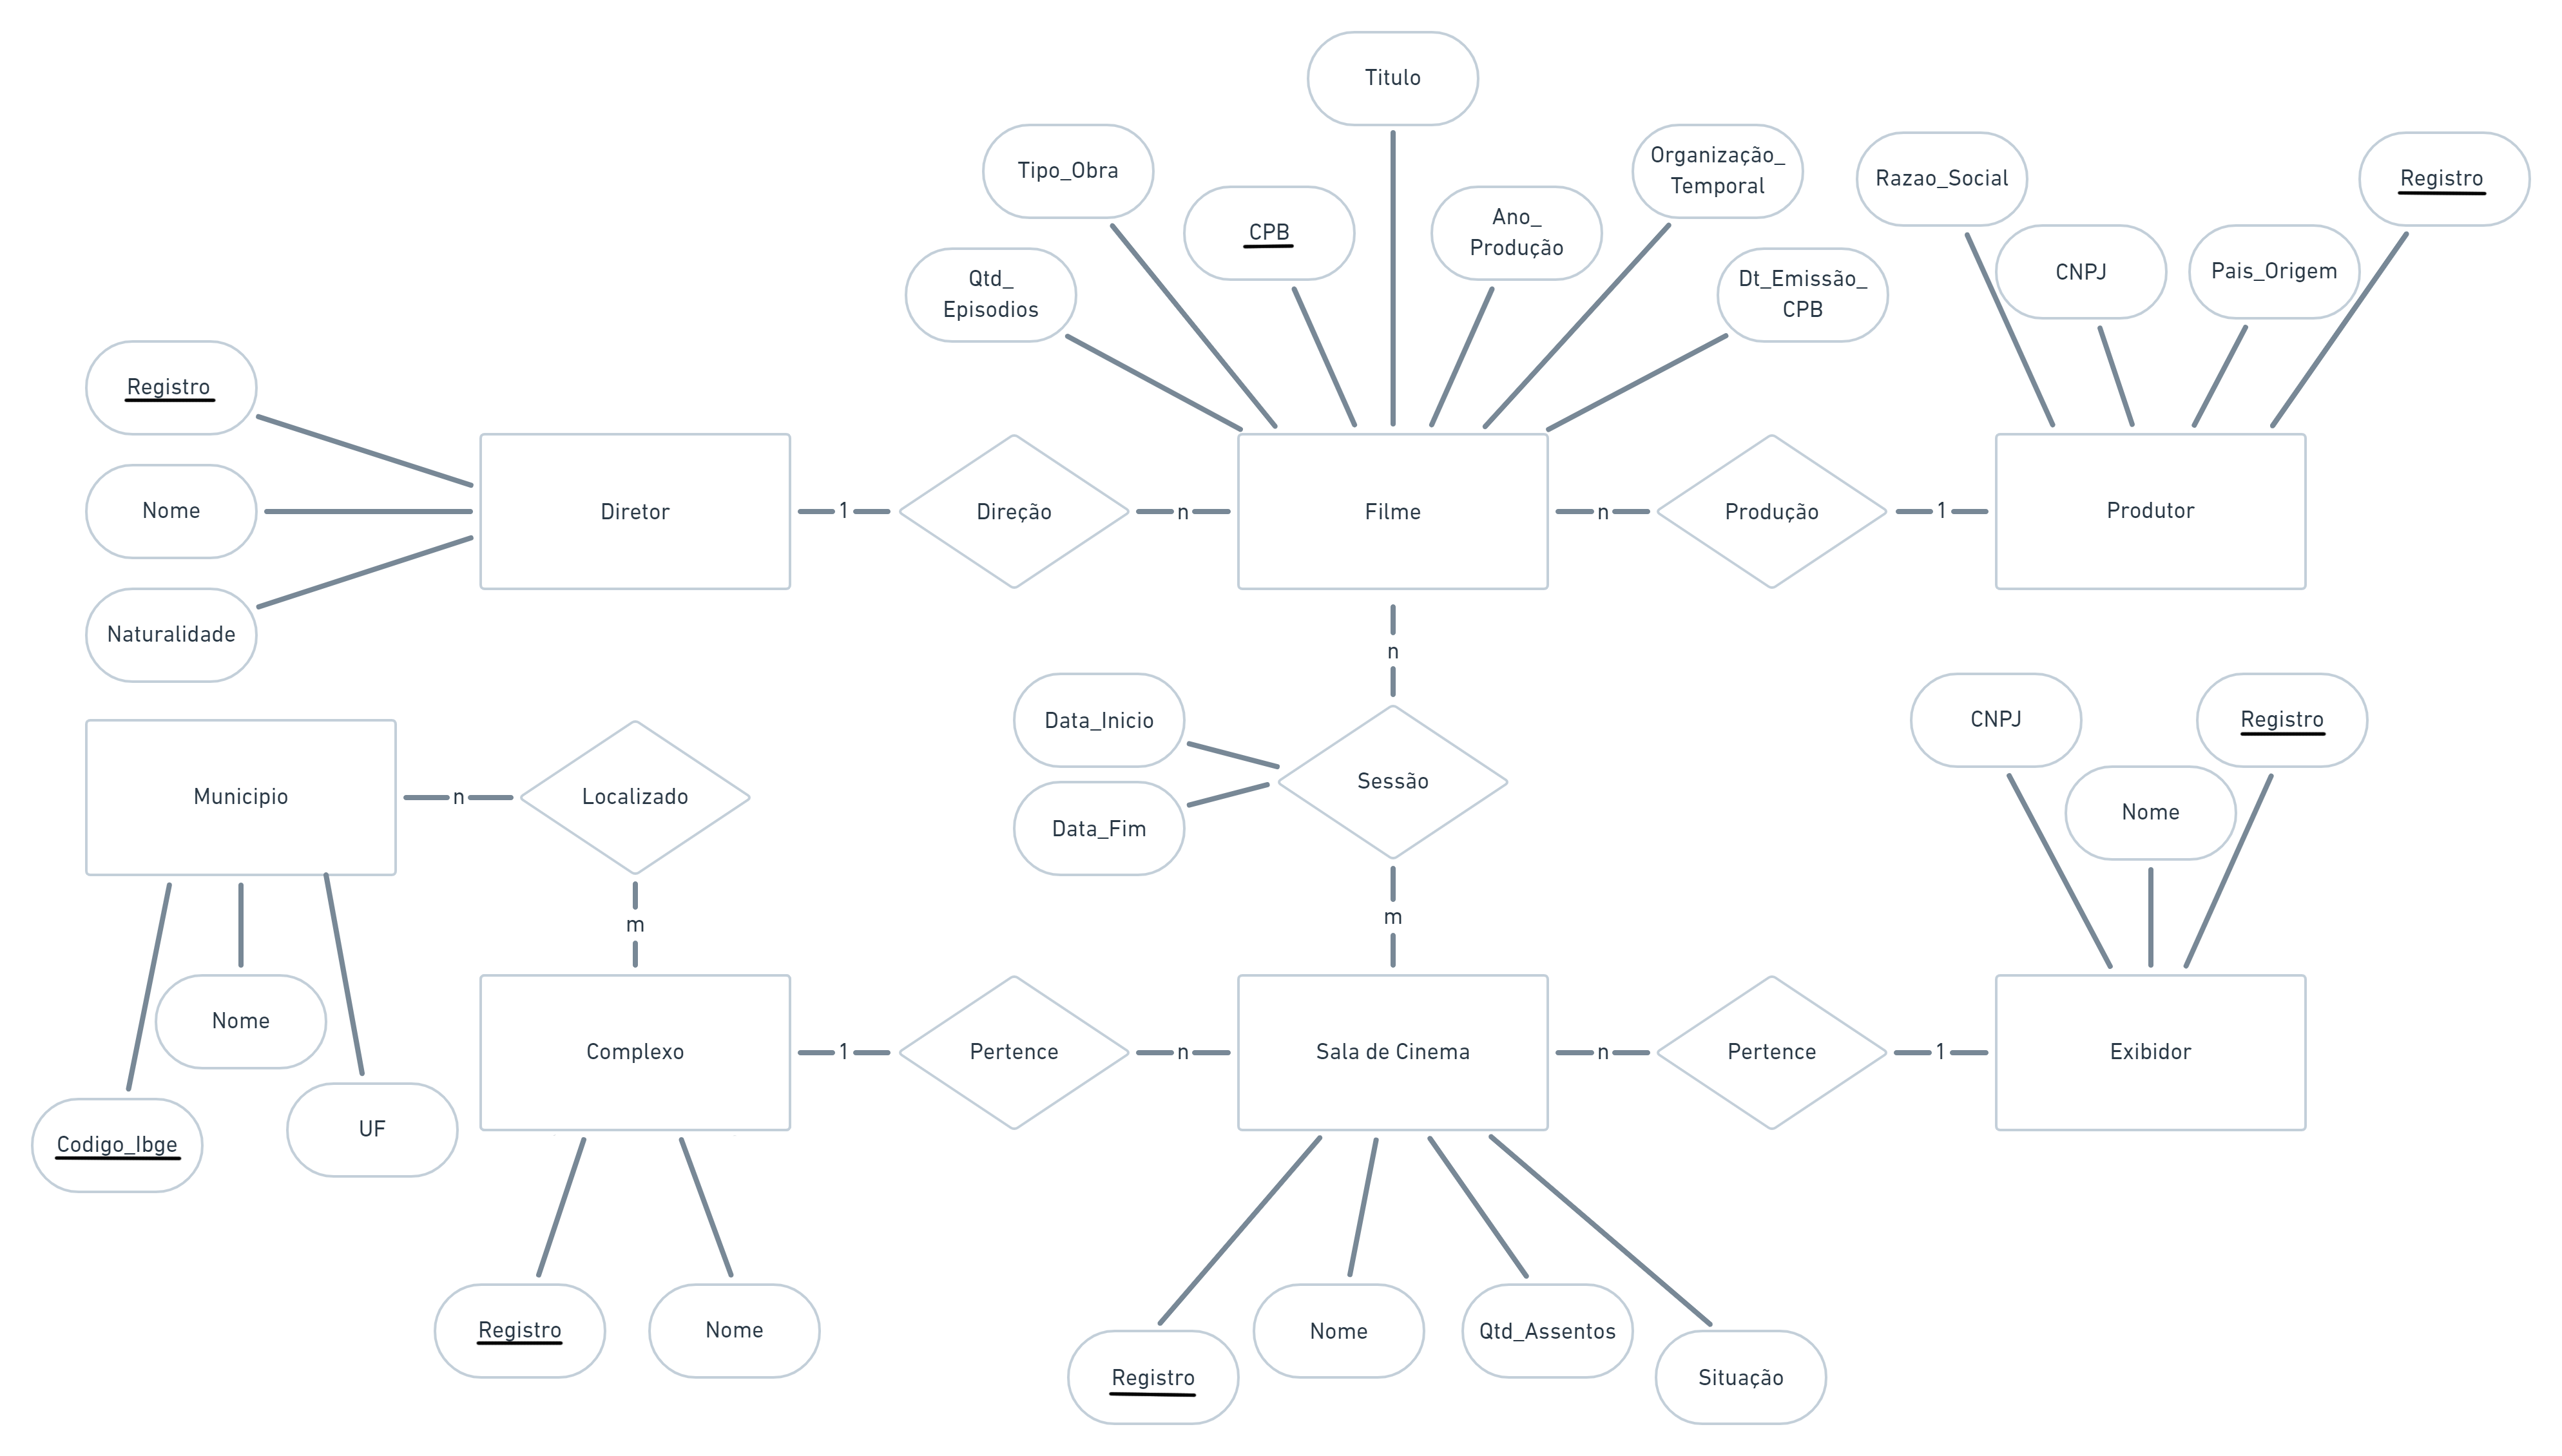

# 5. Diagrama relacional



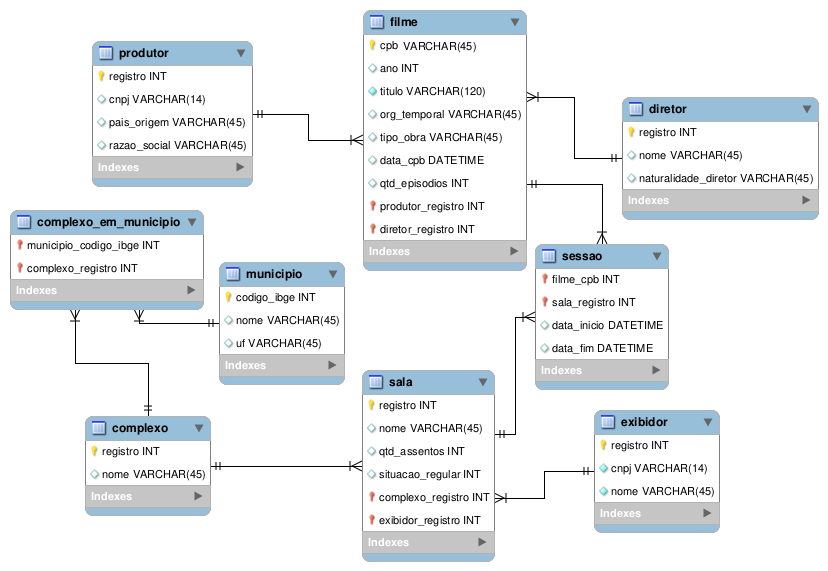

# 6. Consultas

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1 (duas versões)

Todos os diretores que não são brasileiros e têm naturalidade informada.

In [ ]:
# Versão 1
query = """
        SELECT nome,
               naturalidade_diretor
        FROM diretor 
        WHERE naturalidade_diretor != 'BRASIL'
        AND   naturalidade_diretor != 'Não Informado'
        """
%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

The slowest run took 5.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 724 µs per loop


,nome,naturalidade_diretor
0,AGOSTINHO MARTINS PEREIRA,PORTUGAL
1,LEONEL EDUARDO BARRIL VIEIRA,PORTUGAL
2,RUY ALEXANDRE GUERRA COELHO PEREIRA,MOÇAMBIQUE
3,LUIS GALVÃO TELES,PORTUGAL
4,RUDOLF BOHM,ÁUSTRIA


In [ ]:
# Versão 2
query = """
SELECT d.nome, 
       d.naturalidade_diretor 
FROM diretor as d 
WHERE d.naturalidade_diretor != 'BRASIL'
AND   d.naturalidade_diretor != 'Não Informado'
"""

%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 637 µs per loop


,nome,naturalidade_diretor
0,AGOSTINHO MARTINS PEREIRA,PORTUGAL
1,LEONEL EDUARDO BARRIL VIEIRA,PORTUGAL
2,RUY ALEXANDRE GUERRA COELHO PEREIRA,MOÇAMBIQUE
3,LUIS GALVÃO TELES,PORTUGAL
4,RUDOLF BOHM,ÁUSTRIA


### 6.1.2 Consulta 2 (duas versões)
Todos os filmes do tipo "Ficção"

In [ ]:
# Versão 1
query = """
SELECT titulo, 
       ano,
       tipo_obra
FROM filme
WHERE tipo_obra = 'FICÇÃO'
"""
%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.82 ms per loop


,titulo,ano,tipo_obra
0,SEJA O QUE DEUS QUISER,2002,FICÇÃO
1,DURVAL DISCOS,2001,FICÇÃO
2,RUA SEIS SEM NUMERO,2002,FICÇÃO
3,DESMUNDO,2001,FICÇÃO
4,DEUS É BRASILEIRO,2001,FICÇÃO
...,...,...,...
549,"QUINTO DOS INFERNOS, O",2002 A 2002,FICÇÃO
550,DONA FLOR E SEUS DOIS MARIDOS,1997 A 1997,FICÇÃO
551,"VIDA COMO ELA É, A",1996 A 1996,FICÇÃO
552,CARGA PESADA,2003 A 2003,FICÇÃO


In [ ]:
# Versão 2
query = """
SELECT  f.titulo,
        f.ano,
        f.tipo_obra
FROM filme AS F
WHERE tipo_obra ="FICÇÃO"
"""
%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.89 ms per loop


,titulo,ano,tipo_obra
0,SEJA O QUE DEUS QUISER,2002,FICÇÃO
1,DURVAL DISCOS,2001,FICÇÃO
2,RUA SEIS SEM NUMERO,2002,FICÇÃO
3,DESMUNDO,2001,FICÇÃO
4,DEUS É BRASILEIRO,2001,FICÇÃO
...,...,...,...
549,"QUINTO DOS INFERNOS, O",2002 A 2002,FICÇÃO
550,DONA FLOR E SEUS DOIS MARIDOS,1997 A 1997,FICÇÃO
551,"VIDA COMO ELA É, A",1996 A 1996,FICÇÃO
552,CARGA PESADA,2003 A 2003,FICÇÃO


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3 (duas versões)

Todos os filmes de diretores chamados Maurício

In [ ]:
# Versão 1
query = """
SELECT f.titulo, d.nome, f.ano, f.qtd_episodios
FROM filme AS f
JOIN diretor AS d
    ON d.registro = f.diretor_registro
WHERE d.nome LIKE 'MAURICIO%'
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.68 ms per loop


,titulo,nome,ano,qtd_episodios
0,"UM DOENTE, SUA IRMÃ E O GRANDE CAMPEONATO DE C...",MAURICIO ARAUJO DE SOUSA,2002 A 2002,5
1,PERDIDOS NO MEIO DO NADA E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
2,"ILHA MISTERIOSA E OUTRAS HISTÓRIAS, A",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
3,CHICO MICO E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
4,"VAMPIRO, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
5,O ESTRANHO SORO DO DR X E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
6,"FONTE DA JUVENTUDE E OUTRAS HISTÓRIAS, A",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
7,"ÓIA A ONÇA, E OTROS CAUSO",MAURICIO ARAUJO DE SOUSA,2002 A 2002,5
8,"PLANO SANGRENTO, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
9,"BICHO PAPÃO E OUTRAS HISTÓRIAS, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,4


In [ ]:
# Versão 2
query = """
SELECT f.titulo, d.nome, f.ano, f.qtd_episodios
FROM filme AS f
JOIN diretor AS d
    ON f.diretor_registro = d.registro
WHERE f.diretor_registro IN
    (SELECT d2.registro
    FROM diretor AS d2
    WHERE d2.nome LIKE 'MAURICIO%')
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.19 ms per loop


,titulo,nome,ano,qtd_episodios
0,"UM DOENTE, SUA IRMÃ E O GRANDE CAMPEONATO DE C...",MAURICIO ARAUJO DE SOUSA,2002 A 2002,5
1,PERDIDOS NO MEIO DO NADA E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
2,"ILHA MISTERIOSA E OUTRAS HISTÓRIAS, A",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
3,CHICO MICO E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
4,"VAMPIRO, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
5,O ESTRANHO SORO DO DR X E OUTRAS HISTÓRIAS,MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
6,"FONTE DA JUVENTUDE E OUTRAS HISTÓRIAS, A",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
7,"ÓIA A ONÇA, E OTROS CAUSO",MAURICIO ARAUJO DE SOUSA,2002 A 2002,5
8,"PLANO SANGRENTO, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,3
9,"BICHO PAPÃO E OUTRAS HISTÓRIAS, O",MAURICIO ARAUJO DE SOUSA,2002 A 2002,4


### 6.2.3 Consulta 4 (duas versões)
Nome e naturalidade de diretores que dirigiram algum filme após 2005

In [ ]:
# Versão 2
query = """
SELECT d.nome, 
       d.naturalidade_diretor 
FROM diretor as d 
JOIN filme f 
    ON f.diretor_registro = d.registro 
WHERE f.ano > 2005
GROUP BY d.nome
"""

%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.88 ms per loop


,nome,naturalidade_diretor
0,ABIGAIL SILVA ALVES DE CASTRO,BRASIL
1,ADHEMAR GONZAGA,Não Informado
2,ADNOR LUNA PITANGA,BRASIL
3,ADOLFO OSVALDO ORICO ROSENTHAL,BRASIL
4,ADRIANA ARAUJO BORGES,Não Informado
...,...,...
310,WALLACE DOWNEY,Não Informado
311,WALTER HUGO KHOURI,Não Informado
312,WILLIAM BONNER,Não Informado
313,ÍTALO CAJUEIRO DE OLIVEIRA,Não Informado


In [ ]:
query = """
SELECT d.nome, 
       d.naturalidade_diretor 
FROM diretor as d 
WHERE d.registro IN
    (SELECT f.diretor_registro
    FROM filme as f
    WHERE f.ano > 2005)
GROUP BY d.nome
"""

%timeit df = pd.read_sql_query(query, conn)
df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.46 ms per loop


,nome,naturalidade_diretor
0,ABIGAIL SILVA ALVES DE CASTRO,BRASIL
1,ADHEMAR GONZAGA,Não Informado
2,ADNOR LUNA PITANGA,BRASIL
3,ADOLFO OSVALDO ORICO ROSENTHAL,BRASIL
4,ADRIANA ARAUJO BORGES,Não Informado
...,...,...
310,WALLACE DOWNEY,Não Informado
311,WALTER HUGO KHOURI,Não Informado
312,WILLIAM BONNER,Não Informado
313,ÍTALO CAJUEIRO DE OLIVEIRA,Não Informado


### 6.2.3 Consulta 5 (duas versões)
Quantas salas cada exibidor possui

In [ ]:
# Versão 1
query = """
SELECT e.nome,
       COUNT(s.registro) AS "Nº de Salas"
FROM exibidor AS e
JOIN sala AS s
    ON s.exibidor_registro = e.registro
GROUP BY e.nome
ORDER BY COUNT(s.registro) DESC
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.42 ms per loop


,nome,Nº de Salas
0,CINEMARK BRASIL SA,521
1,CINEMA ARTEPLEX LTDA,53
2,CINEMAIS CINEMAS LTDA,46
3,CINE A LTDA,39
4,CINE GRACHER LTDA,30
...,...,...
112,CINECLUBE TORRES,1
113,CINECLUBE ÁGORA,1
114,CINEMA DUNAS LTDA,1
115,CINEMA ITAIPAVA LTDA,1


In [ ]:
# Versão 2
query = """
SELECT e.nome,
       COUNT(s.registro) AS "Nº de Salas"
FROM exibidor AS e,
     sala AS s
WHERE s.exibidor_registro = e.registro
GROUP BY e.nome
ORDER BY COUNT(s.registro) DESC
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.44 ms per loop


,nome,Nº de Salas
0,CINEMARK BRASIL SA,521
1,CINEMA ARTEPLEX LTDA,53
2,CINEMAIS CINEMAS LTDA,46
3,CINE A LTDA,39
4,CINE GRACHER LTDA,30
...,...,...
112,CINECLUBE TORRES,1
113,CINECLUBE ÁGORA,1
114,CINEMA DUNAS LTDA,1
115,CINEMA ITAIPAVA LTDA,1


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6 (duas versões)
Todos os filmes que estiveram em cartaz na cidade de Belo Horizonte

In [ ]:
# Versão 1
query = """
SELECT f.titulo, 
       s2.nome, 
       se.data_inicio, 
       se.data_fim 
FROM filme as f
JOIN sessao as se 
    ON se.filme_cpb = f.cpb
JOIN sala as s2 
    ON se.sala_registro = s2.registro
WHERE se.sala_registro IN
    (SELECT registro FROM sala as s
    NATURAL JOIN complexo_em_municipio cem
    JOIN municipio as m 
        ON cem.municipio_codigo_ibge = m.codigo_ibge 
    WHERE m.nome = 'BELO HORIZONTE')
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

10 loops, best of 5: 22.5 ms per loop


,titulo,nome,data_inicio,data_fim
0,SEJA O QUE DEUS QUISER,PATIO SAVACCI 1,2019-08-14,2019-08-22
1,SEJA O QUE DEUS QUISER,CINE PAMPULHA MALL SALA 1,2020-02-13,2020-02-18
2,CARANDIRU DOC,CINE PAMPULHA MALL SALA 6,2019-02-05,2019-02-12
3,"LOBISOMEM E O CORONEL, O",CINE PAMPULHA MALL SALA 5,2019-02-15,2019-02-18
4,VIVA VOZ,PATIO SAVACCI 5,2020-12-01,2020-12-07
...,...,...,...,...
79,OURO NEGRO,CINE PAMPULHA MALL SALA 5,2019-08-19,2019-08-22
80,NA MÃE,ESPAÇO ROMA 1,2019-12-10,2019-12-16
81,"MEIA NOITE COM GLAUBER, A",CINE PAMPULHA MALL SALA 3,2019-04-06,2019-04-14
82,GLOBO RURAL 3,CINE PAMPULHA MALL SALA 5,2019-09-21,2019-09-28


In [ ]:
# Versão 2
query = """
SELECT f.titulo, 
       s.nome, 
       se.data_inicio, 
       se.data_fim 
FROM filme as f
JOIN sessao as se 
    ON se.filme_cpb = f.cpb
JOIN sala as s 
    ON se.sala_registro = s.registro
JOIN complexo as c
    ON c.registro = s.complexo_registro
JOIN complexo_em_municipio as cem
    ON cem.complexo_registro = c.registro
JOIN municipio as m
    ON m.codigo_ibge = cem.municipio_codigo_ibge
WHERE m.nome = 'BELO HORIZONTE'
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

10 loops, best of 5: 23.8 ms per loop


,titulo,nome,data_inicio,data_fim
0,SEJA O QUE DEUS QUISER,PATIO SAVACCI 1,2019-08-14,2019-08-22
1,SEJA O QUE DEUS QUISER,CINE PAMPULHA MALL SALA 1,2020-02-13,2020-02-18
2,CARANDIRU DOC,CINE PAMPULHA MALL SALA 6,2019-02-05,2019-02-12
3,"LOBISOMEM E O CORONEL, O",CINE PAMPULHA MALL SALA 5,2019-02-15,2019-02-18
4,VIVA VOZ,PATIO SAVACCI 5,2020-12-01,2020-12-07
...,...,...,...,...
79,OURO NEGRO,CINE PAMPULHA MALL SALA 5,2019-08-19,2019-08-22
80,NA MÃE,ESPAÇO ROMA 1,2019-12-10,2019-12-16
81,"MEIA NOITE COM GLAUBER, A",CINE PAMPULHA MALL SALA 3,2019-04-06,2019-04-14
82,GLOBO RURAL 3,CINE PAMPULHA MALL SALA 5,2019-09-21,2019-09-28


### 6.3.2 Consulta 7 (duas versões)
Todos os complexos da cidade de São Paulo e quantas salas eles têm.



In [ ]:
# Versão 1
query = """
SELECT c.nome, 
       COUNT(s.registro) AS "Nº de Salas"
FROM sala as s
JOIN complexo as c
    ON c.registro = s.complexo_registro
JOIN complexo_em_municipio as cem
    ON cem.complexo_registro = c.registro
JOIN municipio as m
    ON m.codigo_ibge = cem.municipio_codigo_ibge
WHERE m.nome = "SÃO PAULO"
GROUP BY c.nome
ORDER BY COUNT(s.registro) DESC
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.82 ms per loop


,nome,Nº de Salas
0,716 CINEMARK ARICANDUVA,13
1,710 CINEMARK SP MARKET,11
2,ESPAÇO ITAÚ DE CINEMA POMPÉIA,11
3,687 CINEMARK SHOPPING D,10
4,705 CINEMARK CENTRAL PLAZA,10
5,714 CINEMARK INTERLAGOS,10
6,715 CINEMARK ELDORADO,10
7,684 CINEMARK SANTA CRUZ,9
8,ESPAÇO ITAU DE CINEMA FREI CANECA,9
9,688 CINEMARK MARKET PLACE,8


In [ ]:
#Versão 2
query = """
Select c.nome,
       COUNT(s.registro) AS "Nº de Salas"
FROM sala as s, complexo as c,  
     complexo_em_municipio as cem,
     municipio as m
WHERE c.registro = s.complexo_registro AND
      cem.complexo_registro = c.registro AND
      m.codigo_ibge = cem.municipio_codigo_ibge AND 
      m.nome = "SÃO PAULO"
GROUP BY c.nome
ORDER BY COUNT(s.registro) DESC
"""

%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

1000 loops, best of 5: 1.85 ms per loop


,nome,Nº de Salas
0,716 CINEMARK ARICANDUVA,13
1,710 CINEMARK SP MARKET,11
2,ESPAÇO ITAÚ DE CINEMA POMPÉIA,11
3,687 CINEMARK SHOPPING D,10
4,705 CINEMARK CENTRAL PLAZA,10
5,714 CINEMARK INTERLAGOS,10
6,715 CINEMARK ELDORADO,10
7,684 CINEMARK SANTA CRUZ,9
8,ESPAÇO ITAU DE CINEMA FREI CANECA,9
9,688 CINEMARK MARKET PLACE,8


### 6.3.3 Consulta 8 (duas versões)
Todos os diretores com quem cada produtora trabalhou e quantas vezes elas trabalharam com cada um deles.

In [ ]:
# Versão 1
query = """
SELECT d.nome,
       p.razao_social,
       COUNT(f.cpb) AS "Nº de Filmes Juntos"
FROM produtor as p
JOIN filme as f
    ON f.produtor_registro = p.registro
JOIN diretor as d
    ON f.diretor_registro  = d.registro
GROUP BY d.nome
ORDER BY COUNT(f.cpb) DESC
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

100 loops, best of 5: 4.14 ms per loop


,nome,razao_social,Nº de Filmes Juntos
0,MARCIO LUIS MOTOKANE,FUNDACAO ROBERTO MARINHO,27
1,MÁRCIO MOTOKANE,FUNDACAO ROBERTO MARINHO,23
2,SYLVIO CARLOS BACK,USINA DE KYNO LTDA ME,19
3,MAURICIO ARAUJO DE SOUSA,MAURICIO DE SOUSA PRODUÇÕES SA,15
4,IVAN ESPIRITO SANTO CARDOSO FILHO,TOPAZIO FILMES LTDA,14
...,...,...,...
530,WERNER EDUARDO SCHUNEMANN,M SCHMIEDT PRODUÇÕES LTDA,1
531,WILLIAM BONNER,TV GLOBO LTDA,1
532,WILSON BARROS,BRAS FILMES LTDA,1
533,ÁLVARO ANDRADE GARCIA,CICLOPE LTDA EPP,1


In [ ]:
#Versão 2
query = """
SELECT d.nome,
       p.razao_social,
       COUNT(f.cpb) AS "Nº de Filmes Juntos"
FROM produtor as p, filme as f, diretor as d
WHERE f.produtor_registro = p.registro AND 
      f.diretor_registro  = d.registro
GROUP BY d.nome
ORDER BY COUNT(f.cpb) DESC
"""

%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

100 loops, best of 5: 4.17 ms per loop


,nome,razao_social,Nº de Filmes Juntos
0,MARCIO LUIS MOTOKANE,FUNDACAO ROBERTO MARINHO,27
1,MÁRCIO MOTOKANE,FUNDACAO ROBERTO MARINHO,23
2,SYLVIO CARLOS BACK,USINA DE KYNO LTDA ME,19
3,MAURICIO ARAUJO DE SOUSA,MAURICIO DE SOUSA PRODUÇÕES SA,15
4,IVAN ESPIRITO SANTO CARDOSO FILHO,TOPAZIO FILMES LTDA,14
...,...,...,...
530,WERNER EDUARDO SCHUNEMANN,M SCHMIEDT PRODUÇÕES LTDA,1
531,WILLIAM BONNER,TV GLOBO LTDA,1
532,WILSON BARROS,BRAS FILMES LTDA,1
533,ÁLVARO ANDRADE GARCIA,CICLOPE LTDA EPP,1


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9 (duas versões)
Quantidade de filmes exibidos por complexo. Ordenado da maior quantidade para a menor.

In [ ]:
# Versão 1
query = """
SELECT c.nome AS 'Nome do Complexo', 
       COUNT(f.cpb) AS 'Nº de Filmes'
FROM filme as f
JOIN sessao as se
    ON se.filme_cpb = f.cpb
JOIN sala as s
    ON s.registro = se.sala_registro
JOIN complexo as c
    ON s.complexo_registro = c.registro
GROUP BY c.nome
ORDER BY COUNT(f.cpb) DESC
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

10 loops, best of 5: 23.8 ms per loop


,Nome do Complexo,Nº de Filmes
0,716 CINEMARK ARICANDUVA,77
1,720 CINEMARK PIER 21,70
2,719 CINEMARK DOWNTOWN,63
3,710 CINEMARK SP MARKET,62
4,2107 CINEMARK RIOMAR RECIFE,59
...,...,...
238,SALADEARTE CINE VIVO,2
239,CINE COLOMBO SÃO JOSÉ DO RIO PARDO,1
240,CINE MULTI,1
241,CINE TEATRO SHOPPING SÃO PEDRO,1


In [ ]:
# Versão 2
query = """
SELECT c.nome AS 'Nome do Complexo', 
       COUNT(f.cpb) AS 'Nº de Filmes'
FROM filme as f, 
     complexo as c, 
     sessao as se, 
     sala as s
WHERE se.filme_cpb = f.cpb AND 
      s.registro = se.sala_registro AND   
      s.complexo_registro = c.registro
GROUP BY c.nome
ORDER BY COUNT(f.cpb) DESC 
"""
%timeit df = pd.read_sql_query(query, conn)

df = pd.read_sql_query(query, conn)
display(df)

10 loops, best of 5: 23.3 ms per loop


,Nome do Complexo,Nº de Filmes
0,716 CINEMARK ARICANDUVA,77
1,720 CINEMARK PIER 21,70
2,719 CINEMARK DOWNTOWN,63
3,710 CINEMARK SP MARKET,62
4,2107 CINEMARK RIOMAR RECIFE,59
...,...,...
238,SALADEARTE CINE VIVO,2
239,CINE COLOMBO SÃO JOSÉ DO RIO PARDO,1
240,CINE MULTI,1
241,CINE TEATRO SHOPPING SÃO PEDRO,1


### 6.4.2 Consulta 10 (duas versões)

Quantidade de filmes dirigidos por diretor. Ordenado da maior quantidade para a menor.

In [ ]:
query = """
SELECT d.nome AS 'Nome Diretor',
       d.naturalidade_diretor AS 'Naturalidade',
       count(f.cpb) AS 'Nº de Filmes' 
FROM filme AS f
JOIN diretor AS d
    ON d.registro = f.diretor_registro
GROUP BY d.nome
ORDER BY count(f.cpb) DESC
"""

%timeit df = pd.read_sql_query(query, conn)


df = pd.read_sql_query(query, conn)
display(df)

100 loops, best of 5: 3.54 ms per loop


,Nome Diretor,Naturalidade,Nº de Filmes
0,MARCIO LUIS MOTOKANE,BRASIL,27
1,MÁRCIO MOTOKANE,Não Informado,23
2,SYLVIO CARLOS BACK,BRASIL,19
3,MAURICIO ARAUJO DE SOUSA,BRASIL,15
4,IVAN ESPIRITO SANTO CARDOSO FILHO,BRASIL,14
...,...,...,...
530,WERNER EDUARDO SCHUNEMANN,BRASIL,1
531,WILLIAM BONNER,Não Informado,1
532,WILSON BARROS,Não Informado,1
533,ÁLVARO ANDRADE GARCIA,Não Informado,1


In [ ]:
#Versão 2
query = """
SELECT d.nome AS 'Nome Diretor',
       d.naturalidade_diretor AS 'Naturalidade',
       count(f.cpb) AS 'Nº de Filmes' 
FROM filme AS f, diretor AS d
WHERE d.registro = f.diretor_registro
GROUP BY d.nome
ORDER BY count(f.cpb) DESC
"""
%timeit df = pd.read_sql_query(query, conn)


df = pd.read_sql_query(query, conn)
display(df)

100 loops, best of 5: 2.82 ms per loop


,Nome Diretor,Naturalidade,Nº de Filmes
0,MARCIO LUIS MOTOKANE,BRASIL,27
1,MÁRCIO MOTOKANE,Não Informado,23
2,SYLVIO CARLOS BACK,BRASIL,19
3,MAURICIO ARAUJO DE SOUSA,BRASIL,15
4,IVAN ESPIRITO SANTO CARDOSO FILHO,BRASIL,14
...,...,...,...
530,WERNER EDUARDO SCHUNEMANN,BRASIL,1
531,WILLIAM BONNER,Não Informado,1
532,WILSON BARROS,Não Informado,1
533,ÁLVARO ANDRADE GARCIA,Não Informado,1


# 7. Autoavaliação dos membros

##2019006396

As atividades na qual tive maior participação foram o desenvolvimento do esquema ER, o diagrama relacional e os scripts utilizados para popular o banco de dados. Além disso, estive presente nas reuniões que marcamos, auxiliando os outros integrantes do grupo a resolver as adversidades que foram encontradas ao longo do trabalho, principalmente no tratamento dos dados da ANCINE (o qual apresentava diversos problemas, dificultando o processamento do mesmo). Acredito que minha participação tenha sido adequada e a experiência do trabalho em grupo benéfica, pois aprendi bastante sobre todo o processo de construção de um banco de dados e pude ter alguma interação com os meus colegas, visto que até então eu conhecia praticamente ninguém da minha turma.

##2019006752

Tive participação em todas as etapas de idealização e desenvolvimento do relatório, passando pelo esquema ER e o diagrama relacional até o desenvolvimento do código utilizado para popular o banco de dados e as consultas realizadas. Estive presente em todas as reuniões e auxiliei meus colegas com tudo o que foi necessário. Acredito que minha participação no trabalho foi adequada e essencial. Aprendi bastante sobre a matéria durante o processo e pude conhecer melhor os meus colegas de turma.  

##2018065895

Minha participação se deu por pontuais ajudas em soluções de erros no tratamento de dados extraídos,
participando dos encontros para soluções e construção de consultas. Como o banco da ANCINE 
apresentava problemas, processar os dados foi a parte mais dificultosa. Minha experiência com o 
trabalho no geral foi muito boa, pude conhecer melhor alguns dos meus colegas e sinto que 
trocamos uma experiência importante para todos.

##2020420613

Minhas atividades atribuídas foram o tratamento dos dados extraídos do site do governo, seleção de itens relevantes, edição do vídeo, revisão e formatação do relatório, além de ter participado ativamente nos encontros com ajuda em soluções pontuais de problemas e elaboração e construção das consultas no banco de dados.
As maiores dificuldades foram em lidar com as inconsistências iniciais dos arquivos fornecidos pelo site do governo, porém assim que contornadas o trabalho fluiu bem. 
Considero minha atuação no trabalho padrão, sinto que fui útil aos meus colegas e contribuí positivamente para o desenvolvimento do trabalho.